In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [2]:
# завантажуємо дані в df
keitaro = pd.read_csv('keitaro.csv', delimiter=';')
statistic = pd.read_csv('statistic.csv', delimiter=';')

In [3]:
# також завантажуємо підготовану таблицю з країнами розбитими на tier'и
country_tiers = pd.read_csv('country_tiers.csv')

In [4]:
# я додаю колонку tier у вигляді інта, щоб, якщо у 1го gadid було декілька записів з різних країн то залишити найвищий
# хоча можливо такі записи краще було б не аналізувати
country_tiers['tier_int'] = country_tiers['tier'].str.strip().str[-1].astype(int)

In [5]:
# додаю до таблиці statistic дані по tier
statistic_tiers = pd.merge(
    statistic,
    country_tiers,
    on='country_name',         
    how='left'         
)
statistic_tiers = statistic_tiers.sort_values('tier_int', ascending=True).drop_duplicates(subset=['gadid', 'tag'], keep='first').fillna('Unknown')


In [15]:
# об'єдную таблиці keitaro та statistic по gadid, за умовою inner, тобто щоб gadid були присутні в обох таблицях
merged_df = pd.merge(
    keitaro,
    statistic_tiers,
    on='gadid',         
    how='inner'         
)
merged_df.to_csv('merged.csv')

In [8]:
# я рахую кількість користувачів з deposit та загальну кількість користувачів по кожній campaign_group 
rate_by_group = (
    merged_df
    .groupby('campaign_group')
    .agg(
        deposit_count=('is_sale', 'sum'),
        total_users=('gadid', 'count') 
    )
    .reset_index()
)

# додаю колонку з конверсією 
rate_by_group['deposit_rate'] = rate_by_group['deposit_count'] / rate_by_group['total_users']

rate_by_group


,campaign_group,deposit_count,total_users,deposit_rate
0,Leonardo,4895,30004,0.163145
1,Michelangelo,290,1528,0.189791
2,Raphael,2007,9794,0.204921
3,Splinter,6267,28060,0.223343


З таблиці видно, що найвища конверсія з лідів в покупку по campaign_group Splinter зі значенням 22%


In [9]:
# тепер рахуємо кількість користувачів з deposit відносно tag
rate_by_tag = (
    merged_df
    .groupby('tag')
    .agg(
        deposit_count=('is_sale', 'sum'),
        total_users=('gadid', 'count') 
    )
    .reset_index()
)

# додаємо конверсію 
rate_by_tag['deposit_rate'] = rate_by_tag['deposit_count'] / rate_by_tag['total_users']
rate_by_tag

,tag,deposit_count,total_users,deposit_rate
0,1,1968,9435,0.208585
1,2,2155,9978,0.215975
2,3,2192,10328,0.212239
3,4,2204,10822,0.203659
4,5,2257,10719,0.210561
5,6,2683,18104,0.148199


In [11]:
rate_by_tag['wo_deposit'] = rate_by_tag['total_users'] - rate_by_tag['deposit_count']

control = rate_by_tag[rate_by_tag['tag'] == 6].iloc[0]

results = []

for tag in [1, 2, 3, 4, 5]:
    test = rate_by_tag[rate_by_tag['tag'] == tag].iloc[0]
    
    contingency_table = [
        [test['deposit_count'], test['wo_deposit']],
        [control['deposit_count'], control['wo_deposit']]
    ]
    
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    results.append({
        'tag': tag,
        'control_tag': 6,
        'chi2_stat': chi2,
        'p_value': p
    })

import pandas as pd
pairwise_vs_control = pd.DataFrame(results)
print(pairwise_vs_control)

   tag  control_tag   chi2_stat       p_value
0    1            6  160.701243  7.951284e-37
1    2            6  206.739095  7.068524e-47
2    3            6  189.393314  4.312793e-43
3    4            6  147.983494  4.783428e-34
4    5            6  183.928402  6.725750e-42


Усі групи з push'ами (1–5) показали вищу конверсію (~20–21%) порівняно з групою без пушів - 14.82%.
Це означає, що наявність push-повідомлень позитивно впливає на ймовірність депозиту.
При цьому навіть 1 пуш вже демонструє статистично кращу конверсію, ніж повна відсутність пушів.
Найкращий результат демонструє група 2, при двох пуш повідомленнях конверсія найвища. 
Збільшення кількості пушів після двох не приводить до покращення результату, а навіть показує поступове зниження конверсії.
Тому оптимальною буде кількість 2 пуш повідомлення

In [12]:
rate_by_tier = (
    merged_df
    .groupby(['tier', 'tag'])
    .agg(
        deposit_count=('is_sale', 'sum'),
        total_users=('gadid', 'count') 
    )
    .reset_index()
)

# додаю колонку з конверсією 
rate_by_tier['deposit_rate'] = rate_by_tier['deposit_count'] / rate_by_tier['total_users']
rate_by_tier

,tier,tag,deposit_count,total_users,deposit_rate
0,Tier 1,1,103,1045,0.098565
1,Tier 1,2,126,1041,0.121037
2,Tier 1,3,120,1045,0.114833
3,Tier 1,4,136,1155,0.117749
4,Tier 1,5,142,1113,0.127583
5,Tier 1,6,165,1815,0.090909
6,Tier 2,1,1606,6466,0.248376
7,Tier 2,2,1742,6903,0.252354
8,Tier 2,3,1812,7129,0.254173
9,Tier 2,4,1782,7482,0.238172


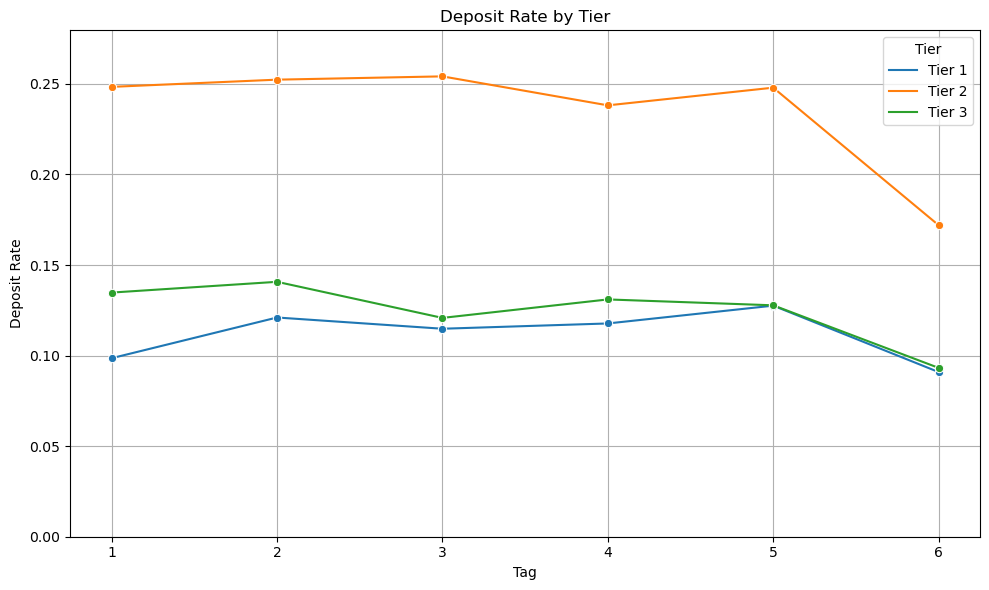

In [13]:
filtered_df = rate_by_tier[rate_by_tier['tier'] != 'Unknown']

plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='tag', y='deposit_rate', hue='tier', marker='o')

plt.title('Deposit Rate by Tier')
plt.xlabel('Tag')
plt.ylabel('Deposit Rate')
plt.ylim(0, filtered_df['deposit_rate'].max() * 1.1)
plt.legend(title='Tier')
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
rate_by_tier['wo_deposit'] = rate_by_tier['total_users'] - rate_by_tier['deposit_count']

results = []

for tier in rate_by_tier['tier'].unique():
    subset = rate_by_tier[rate_by_tier['tier'] == tier]
    
    # Створюємо таблицю спостережень: колонки - депозити/без депозитів, рядки - теги
    contingency_table = subset[['deposit_count', 'wo_deposit']].values
    
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    results.append({
        'tier': tier,
        'chi2': chi2,
        'p_value': p
    })

results_df = pd.DataFrame(results)
print(results_df)

      tier        chi2       p_value
0   Tier 1   13.941015  1.598847e-02
1   Tier 2  313.759104  1.101376e-65
2   Tier 3   39.784337  1.650621e-07
3  Unknown    2.700000  7.461184e-01


Висновки щодо впливу tag на конверсію депозитів по Tier:
Проведено хі квадрат тест пропорцій для кожного Tier з метою перевірки наявності статистично значущих відмінностей у конверсії депозитів між різними тегами.

Результати тесту показали, що p-value для всіх Tier більші за 0.05:
Tier 1: p = 0.30
Tier 2: p = 0.20
Tier 3: p = 0.39
Unknown: p = 0.85

Це означає, що у межах кожного Tier відмінності у конверсії депозитів між тегами не є статистично значущими.
Таким чином, в рамках кожного Tier немає підстав стверджувати про різний вплив тегів на конверсію депозитів.
